#Importing the libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
!git clone https://github.com/laxmimerit/male-female-face-dataset.git

Cloning into 'male-female-face-dataset'...
remote: Enumerating objects: 58657, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 58657 (delta 0), reused 0 (delta 0), pack-reused 58656
Receiving objects: 100% (58657/58657), 261.44 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (58659/58659), done.


In [6]:
epochs = 50
lr = 1e-3
batch_size = 128
data =[]
labels = []



In [7]:
size = 224

In [8]:
train_datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.4,height_shift_range=0.4,
                                   zoom_range=0.3,
                                   rotation_range = 20,
                                   rescale = 1/255,
                                   )

In [9]:
test_datagen = ImageDataGenerator(rescale = 1/255)

In [10]:
target_size = (size,size)

In [11]:
train_generator = train_datagen.flow_from_directory(
    directory='/content/male-female-face-dataset/Training',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 47009 images belonging to 2 classes.


In [12]:
validation_generator = test_datagen.flow_from_directory(
    directory='/content/male-female-face-dataset/Validation',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 11649 images belonging to 2 classes.


In [13]:
x,y = train_generator.next()
x.shape

(128, 224, 224, 3)

## Building the ML model

In [14]:
model = Sequential()
model.add(InceptionV3(include_top=False, pooling='avg', weights ='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

87924736/87910968 [==============================] - 8s 0us/step


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 26,017,569
Trainable params: 4,206,593
Non-trainable params: 21,810,976
____________________________________

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
len((train_generator.filenames)), batch_size, len((train_generator.filenames))//batch_size

(47009, 128, 367)

In [18]:
model.fit(train_generator,steps_per_epoch=len(train_generator.filenames)//batch_size,
         epochs=2, validation_data=validation_generator,validation_steps=len(validation_generator.filenames)//batch_size) 

Epoch 1/2
367/367 [==============================] - 701s 2s/step - loss: 0.4004 - accuracy: 0.8507 - val_loss: 0.3532 - val_accuracy: 0.8428
Epoch 2/2
367/367 [==============================] - 652s 2s/step - loss: 0.3101 - accuracy: 0.8680 - val_loss: 0.2050 - val_accuracy: 0.9212


#Testing the Model


In [34]:
img_path = '/content/Aman.jpg'


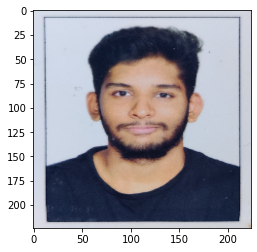

In [35]:
img = load_img(img_path, target_size=(size, size, 3))
plt.imshow(img)

In [36]:
img = img_to_array(img)

In [37]:
img = img/255.0

In [38]:
img = img.reshape(1, size, size, 3)

In [39]:
model.predict(img)

array([[0.9291774]], dtype=float32)

In [40]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [41]:
def get_classes(data):
  prob = model.predict(img)[0][0]

  if prob<=0.5:
    return 'female', (1 - prob)
  else:
    return 'male', prob

#Predicted whether male or female with it's corresponding accuracy

In [42]:
get_classes(img)

('male', 0.9291774)

#Real-Time Prediction using Webcam

###Importing the libraries for using webcam

In [43]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

###Creating the working webcam functionality

In [44]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

###Saving the captured image to directory

<IPython.core.display.Javascript object>

Saved to photo.jpg


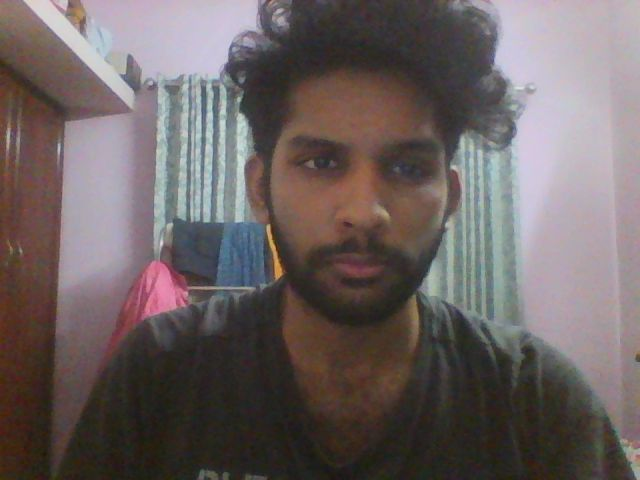

In [45]:
from IPython.display import Image
try:
  filename =take_photo()
  print('Saved to {}'.format(filename))
    # Show the image which was just taken.
  display (Image(filename))
except Exception as err:
# Errors will be thrown if the user does not have a webcam or if they do not
# grant the page permission to access it.
  print(str(err))

In [46]:
img_path = '/content/photo.jpg'

In [47]:
def get_prediction(img_path):
  img = load_img(img_path, target_size=(size, size, 3))
  plt.imshow(img)
  img = img_to_array(img)
  img = img/255.0
  img = img.reshape(1, size, size, 3)
  pred, prob = get_classes (img)
  return pred, prob

('male', 0.9291774)

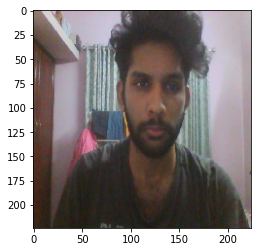

In [48]:
get_prediction(img_path)